 # Проектная работа. Приложение "Procrastinate Pro+"

В нашем распоряжении данные Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года.


**Цель исследования** будет состоять из следующих пунктов:
1. Составить портреты пользователей.
2. Проанализировать зависимости выручки компании от страны пользователя, его девайса и способа привлечения.
3. Проанализировать цены на маркетинг и выявить наиболее эффективнвые и неэффективные затраты компании.
4. Оценить окупаемость рекламы.


**Ход исследования**

В нашем распоряжении 3 файла. Файл 'visits_info_short.csv' хранит лог сервера с информацией о посещениях сайта, 'orders_info_short.csv' — информацию о заказах, а 'costs_info_short.csv' — информацию о расходах на рекламу. О качестве данных ничего не известно, поэтому перед  исследованием понадобится провести обзор данных.

На этапе предобработки данных надо будет проанализировать данные и внести изменения в таблицы, если понадобится. Так же необходимо будет изучить тип данных и изменить их, если потребуется. Помимо этого, стоит проверить на дубликаты.

Следующим пунктом будет составление профилей пользователей для дальнейших рачетов и нахождения зависимостей.

Так же надо будет проверить, окупается ли реклама. Если нет, то следует найти причины этого и предложить решение.

Финальным будет исследовательский анализ с выявлением закономерностей, построением графиков и создание соответствующих выводов.
Таким образом, исследование пройдёт в шесть этапов:
 1. Предобработка данных
 2. Функции для расчёта и анализа LTV, ROI, удержания и конверсии
 3. Исследовательский анализ данных
 4. Маретинг
 5. Окупаемость рекламы
 6. Вывод и рекомендации

## Предобработка данных

In [1]:
import pandas as pd #В процессе будут использованы данные библитотеки в такой же последовательности
from datetime import datetime, timedelta
import numpy as np
from matplotlib import pyplot as plt

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Видим сразу несколько вещей:
1. В названиях столбцов присутствует верхний регистр и пробелы. Так можно, но по правилам хорошего стиля мы от них избавимся
2. Некоторые столбцы имеют некорректный тип данных, например, 'Session End'. Его и все прочие мы переведем в необходимый, конкретно здесь - datetime

In [4]:
visits.columns = visits.columns.str.lower()
visits.columns = visits.columns.str.replace(' ', '_') 
visits[visits['session_start'] > 'session_end'] #Небольшая проверка на ошибки в данных(время начала сессии позже ее конца)

,user_id,region,device,channel,session_start,session_end


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [6]:
orders.columns = orders.columns.str.lower()
orders.columns = orders.columns.str.replace(' ', '_') 
(orders['revenue'] <= 0).sum() #Жалко, что суммы заказа нет отрицательной. Делают заказ и нам еще доплачиают

0

In [7]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [8]:
costs.columns = costs.columns.str.lower()
(costs['costs'] <=0).sum() #И расходов нулевых нет. Вроде и хорошо, а вроде и нет...

0

In [9]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Ну здесь все так же, как и было написано выше, за исключением последней строчки. Дело в том, что далее, когда мы будем создавать профили клиентов (profilies) нам будет необходимо, чтобы столбец costs['dt'] был приведен в дату с помощью dt.date, а не datetime(так как нам нужна дата в функции get_profiles). Но, несмотря на то, что в информации о столбце будет висеть тип object - это неправда, так как там формат date

In [10]:
display(visits.duplicated().sum())
display(orders.duplicated().sum())
costs.duplicated().sum()

0

0

0

Видим, что явных дубликатов нет ни в 1 из наших датафреймов

**Вывод:** проанализировали исходные данные, поменяли представление данных, изменили названия самих столбцов, проверили на явные дубликаты. На неявные не стали проверять, так как крайне сложно найти подобающие критерии. Самым логичным кажется 'user_id' и 'session_start' в 'visits', например, но пользователь может зайти одновременно с нескольких устройств или некорректная обработка данных сайта. В любом случае, далее нам понадобятся уникальные пользователи, поэтому оставим все так

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [11]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['week'] = profiles['first_ts'].astype('datetime64[W]')
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [12]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [13]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [14]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [15]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [16]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [17]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [18]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

Здесь мы ставим перед собой несколько задач:
- Составить профили пользователей и определить минимальную и максимальную даты привлечения пользователей.
- Выяснить, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построить таблицу, отражающую количество пользователей и долю платящих из каждой страны. Аналогично с устройствами.
- Изучить рекламные источники привлечения и определить каналы, из которых пришло больше всего платящих пользователей. Построить таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

Стоит отметить, что все выводы(промежуточные под задачами и обобщающие в конце пункта) мы делаем на основе данных, полученных здесь или ранее. К примеру, если мы в 3 пункте получим, что самая прибыльная страна - Франция, а в 5 пункте мы узнаем, что привлекать клиентов из Франции экономически неэффективно, все равно в 3, 4 и начале 5 пункта(пока мы не узнаем об этом) мы будем писать, что Франция - наш выбор, потому что крайне эффективна экономически и башня у них классная

In [19]:
profiles = get_profiles(visits, orders, costs)
print(profiles.head(5)) 
profiles.info()

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt       week      month  payer  acquisition_cost  
0  2019-05-07 2019-05-02 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-04 2019-07-01  False          1.107237  
2  2019-10-01 2019-09-26 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-09-26 2019-10-01  False          0.230769  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            ------------

In [20]:
profiles.duplicated().sum() #Ну на всякий случай

0

In [21]:
display(profiles['first_ts'].dt.date.min())
display(profiles['first_ts'].dt.date.max())

datetime.date(2019, 5, 1)

datetime.date(2019, 10, 27)

Определили минимальную(1 мая 2019) и максимальную(27 октября 2019) даты привлечения пользователей. 

Так как в ТЗ были указаны те же даты, можно сделать вывод, что данные корректны

Далее мы будем анализировать распределение использования приложения в разных странах, устройствах и из разных источников привлечения. Помимо процента платящих пользователей страны(устройства и т.д.) мы также будем выяснять, какой это процент пользователей из всех, кто использовал приложение.

In [22]:
region_table = (
    profiles.groupby('region')
    .agg({'user_id' : 'nunique', 'payer' : 'mean'})
    .sort_values(by='payer', ascending=False)
)
region_table['payer'] *= 100 # Переводим в проценты для удобства чтения
region_table['percent'] = region_table['payer'] * region_table['user_id'] / region_table['user_id'].sum() 
region_table

,user_id,payer,percent
region,,,
United States,100002,6.901862,4.601088
Germany,14981,4.111875,0.410645
UK,17575,3.982930,0.466642
France,17450,3.799427,0.441976


Видим, что с огромным перевесом по количеству пользователей лидируют США, помимо этого, у нее самый высокий процент людей, совершивших покупку в приложении (6.9 процентов), а также самый высокий процент пользователй, совершивших покупку, по отношению ко всем пользователям (4.6 процента)

Остальные страны расположились +- ровно, поэтому нет смысла судить о том, что UK лучше Франции, потому что там процент платящих на 0.2 процента выше, количество пользователей на 125 человек больше, а процент купивших ко всем пользователям - на 0.02 процента выше

In [23]:
device_table = (
    profiles.groupby('device')
    .agg({'user_id' : 'nunique', 'payer' : 'mean'})
    .sort_values(by='payer', ascending=False)
)
device_table['payer'] *= 100
device_table['percent'] = device_table['payer'] * device_table['user_id'] / device_table['user_id'].sum()
device_table

,user_id,payer,percent
device,,,
Mac,30042,6.364423,1.274599
iPhone,54479,6.207897,2.254546
Android,35032,5.851793,1.366594
PC,30455,5.046790,1.024612


Здесь в лидеры по проценту купивших граждан попадают владельцы Mac, но с небольшим перевесом(6.36 процента), тогда как на 2 месте iPhone (6.21 процент). Но пользоветелей iPhone больше, именно поэтому в пересчете количества купивших людей в общему числу пользователей на первом месте - iPhone.

На последнем месте уверенно расположились пользователи PC, у них самый низкий процент пользователей, выполнивших целевое действие (5 процентов), и их отношение ко всем пользователям (1 процент).

Так же стоит отметить, что Mac и iPhone сильно отрываются от Andoid-a и PC в проценте людей, совершивших покупку.

In [24]:
channel_table = (
    profiles.groupby('channel')
    .agg({'user_id' : 'nunique', 'payer' : 'mean'})
    .sort_values(by='payer', ascending=False)
)
channel_table['payer'] *= 100
channel_table['percent'] = channel_table['payer'] * channel_table['user_id'] / channel_table['user_id'].sum()
display(channel_table)
channel_table.sort_values(by='percent', ascending=False)

,user_id,payer,percent
channel,,,
FaceBoom,29144,12.204914,2.371207
AdNonSense,3880,11.340206,0.293318
lambdaMediaAds,2149,10.469986,0.149992
TipTop,19561,9.600736,1.251933
RocketSuperAds,4448,7.913669,0.234654
WahooNetBanner,8553,5.296387,0.301984
YRabbit,4312,3.826531,0.109994
MediaTornado,4364,3.574702,0.103994
LeapBob,8553,3.063253,0.174657


,user_id,payer,percent
channel,,,
FaceBoom,29144,12.204914,2.371207
TipTop,19561,9.600736,1.251933
organic,56439,2.055316,0.773292
WahooNetBanner,8553,5.296387,0.301984
AdNonSense,3880,11.340206,0.293318
RocketSuperAds,4448,7.913669,0.234654
LeapBob,8553,3.063253,0.174657
OppleCreativeMedia,8605,2.707728,0.155325
lambdaMediaAds,2149,10.469986,0.149992


Тут целых 11 источников, поэтому я сделал 2 таблички с сортировкой по убыванию процента платящих пользователей среди своей когорты и по убыванию процента таких людей по отношению к общему числу людей

Бесприкословным лидером здесь является Faceboom, так как процент купивших людей здесь максимальный(12 процентов) и процент таких людей к общему количеству тоже максимальный(2.37 процента). да и людей больше, чего греха таить...

А вот дальше уже интереснее - на 2 месте по платящим расположился канал AdNon Sense(11 процентов), но из данного канала привлечения пришло всего лишь 3880 человек. Здесь получается более точечная реклама, как и в lambdaMediaAds.

На 2 месте по проценту платящих пользоватей ко всем привлеченным находится TipTop(1.25 процента), но это из-за большого охвата пользователей, так как процент платящих людей в самом приложении составил 9.6 процента, что позволило TipTop-у занять всего лишь 4 строчку в 1 таблице. ~TipTop не такой уж и Top, как оказалось~

**Подытог:**
1. Наибольшее количество пользователей, количество платящих пользователей и их количество по отношению ко всем скачавшим находится в США
2. Наиболее часто покупки совершают пользователи Mac или iPhone, причем, пользователей iPhone гораздо больше, чем пользователей любого другого устройства. Наименее часто покупки совершались пользователями с ПК ~где-то далеко играет He's A Pirate~
3. Наилучший канал для привлечения платежеспособных клиентов - FaceBoom с 12 процентами людей, совершивших целевое действие (2.37 процента от общего числа). С точки зрения процента платежеспособных клиентов на 2 месте - AdNonSense(11 процентов с целевым действием), но количество привлеченных людей в 7 раз ниже, чем у FaceBoom-а. С точки зрения количества клиентов на 2 месте расположился TipTop (19500 людей, 1.25 процента платежеспособных людей по отношению к общему числу), но у него процент платящих ниже - 9.6 процента. Наихудшие каналы - LeapBob и OppleCreativeMedia (3 и 2.7 процента платящих)

## Маркетинг

 Здесь план следующий:
- Считаем общую сумму расходов на маркетинг.
- Изучаем распределение трат по рекламным источникам, корректируем выводы по прошлому пункту.
- Строим графики динамики изменения расходов во времени по каждому источнику.
- Узнаем среднюю стоимость привлечения одного пользователя (CAC) из каждого источника.

In [25]:
round(profiles['acquisition_cost'].sum(), 2) # Суммарные затраты на маркетинг

105497.3

In [26]:
profiles.groupby('channel')['acquisition_cost'].sum().sort_values(ascending=False)

channel
TipTop                54751.30
FaceBoom              32445.60
WahooNetBanner         5151.00
AdNonSense             3911.25
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
LeapBob                1797.60
lambdaMediaAds         1557.60
MediaTornado            954.48
YRabbit                 944.22
organic                   0.00
Name: acquisition_cost, dtype: float64

Видим, что наибольшие затраты уходят на TipTop, а на 2 месте находится FaceBoom. Помня, что реклама в FaceBoom наиболее эффективна, можно сделать вывод, что ситуация, которая видна сейчас, в корне неверна - у TipTop-а слишком большие затраты (54.7к по сравнению с 32.4к у FaceBoom-а). 3 место так же не внушает доверия(WahooNetBanner), так как данная компания находится на 6 месте по проценту платящих пользователей. 

А вот на 4 месте находится AdNonSense, который, как мы помним из прошлого пункта, крайне релевантен (занимает 2 место по количеству купивших людей), но на него затраты куда меньше, чем могли бы быть

Соответственно, можно скорректировать выводы по прошлому пункту так: следует уменьшить маркетинговые акции с компанией TipTop и увеличить их с AdNonSense. Да и с lambdaMediaAds тоже можно увеличить количество рекламы, так как данная компания находится на 3 месте в нашем рейтинге

<AxesSubplot:title={'center':'Динамика изменения расходов по времени по источникам'}, xlabel='week', ylabel='summary_acquisition_cost'>

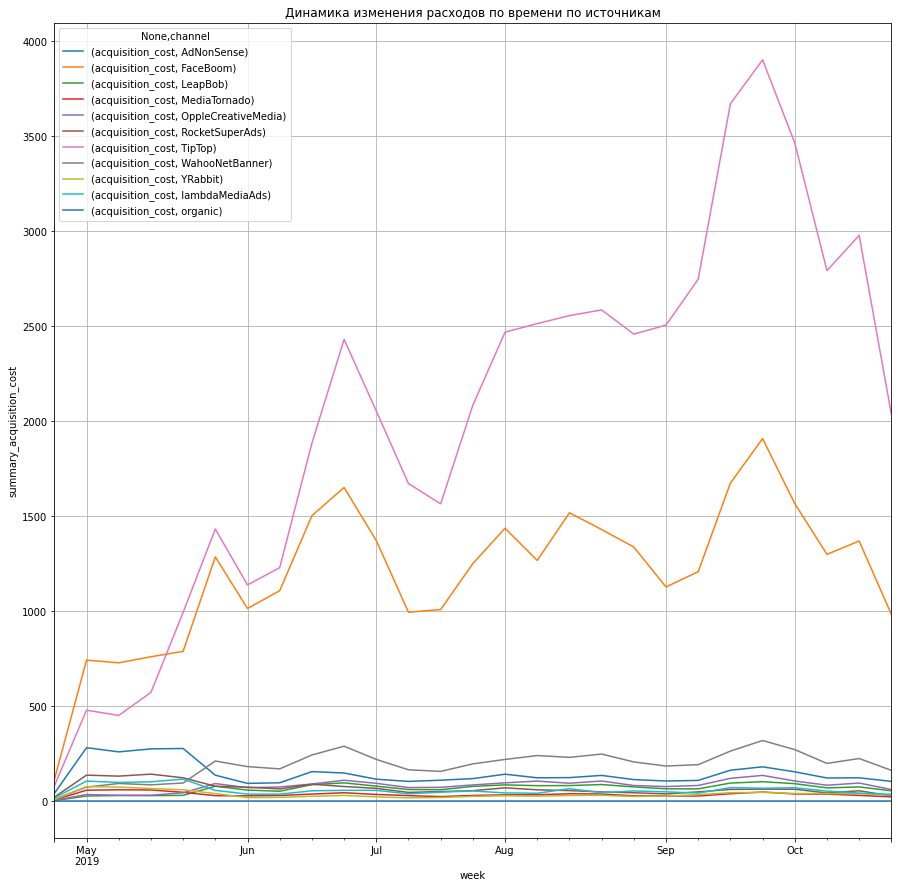

In [27]:
display(profiles
        .groupby(['week', 'channel'])
        .agg({'acquisition_cost' : 'sum'})
        .pivot_table(index='week', columns='channel')
        .plot(grid=True, figsize=(15, 15), xlabel='week', ylabel='summary_acquisition_cost'
              ,title='Динамика изменения расходов по времени по источникам'))

<AxesSubplot:title={'center':'Динамика изменения расходов по времени по источникам'}, xlabel='month', ylabel='summary_acquisition_cost'>

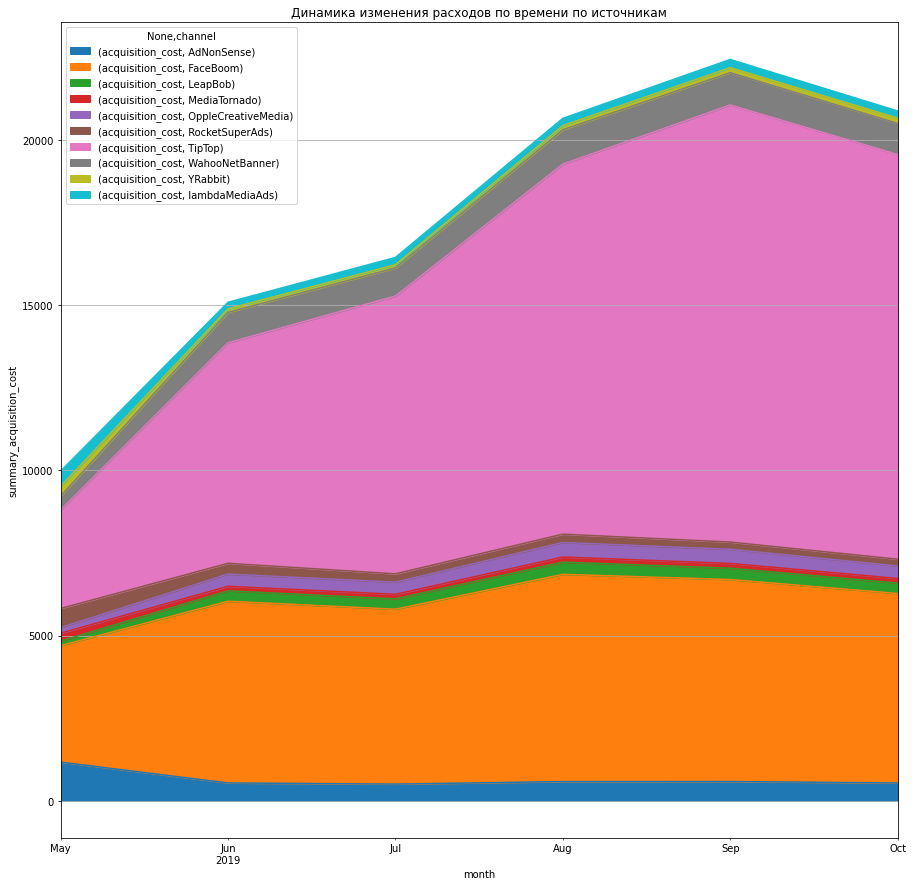

In [46]:
display(profiles
        .groupby(['month', 'channel'])
        .agg({'acquisition_cost' : 'sum'})
        .pivot_table(index='month', columns='channel')
        .plot(grid=True, figsize=(15, 15), xlabel='month', ylabel='summary_acquisition_cost', kind='area'
              ,title='Динамика изменения расходов по времени по источникам'))

Здесь более наглядно представлено распределение, в частности, видим крайне высокие расходы на TipTop(топ-1 по тратам), хотя FaceBoom занимает почетное 2 место с большим отрывом от 1. Все так же считаю, что Faceboom и AdNonSense - самые лучшие компании. Как минимум, потому, что у них самые высокие проценты пользователей, совершивших покупку, как максимум - AdNonSense находится на 4 месте по суммарным затратам и на 2 по проценту купивших продукт людей.

Было простроено 2 графика - суммарные траты по неделям и месяцам. Видим ситуацию, описаную выше - высокие траты не TipTop и FaceBoom, но на графике по месяцам ситуация более сглаженная, так как по неделям траты могли взлетать или падать, тогда как на графике по месяцам можно смотреть, как быстро расли затраты на TipTop

In [30]:
cac = (
    profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
    .sort_values(by='cac', ascending=False)
)
cac

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


**Вывод:** Наибольшая стоимость привлечения клиента и общие затраты у TipTop(как удивительно), на 2 месте расположился FaceBoom.  На 3 месте - AdNonSense. Самая низкая стоимость привлечения клиентов у LeapBob, MediaTornado, YRabbit и OppleCreativeMedia, но последняя имеет крайне низкий процент пользователей, совершивших целевое действие, поэтому эту компанию мы не учитываем.

По возможности надо будет использовать каналы привлечения с минимальным CAC, так как сейчас у нас наибольшие закупки у компаний с наибольшим CAC

## Окупаемость рекламы

С помощью графиков LTV, ROI и CAC проанализируем окупаемость рекламы. Считаем, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. При анализе не будем включать органических пользователей, так как их стоимость привлечения равна 0, а нам интерена окупаемость рекламы

План будет следующий:

- Анализ окупаемости рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Анализ конверсии пользователей и динамики её изменения. То же самое  с удержанием пользователей. Построение и изучение графиков конверсии и удержания.
- Анализ окупаемости рекламы с разбивкой по устройствам, странам, рекламным каналам. Построение графиков LTV и ROI и графиков динамики LTV, CAC и ROI.
- Ответ на финальные вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?


In [31]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

Исключим пользователей с органическим трафиком, так как мы за них не платим, а нам необходимо изучить окупаемость рекламы

In [32]:
profiles = profiles.query('channel != "organic"')

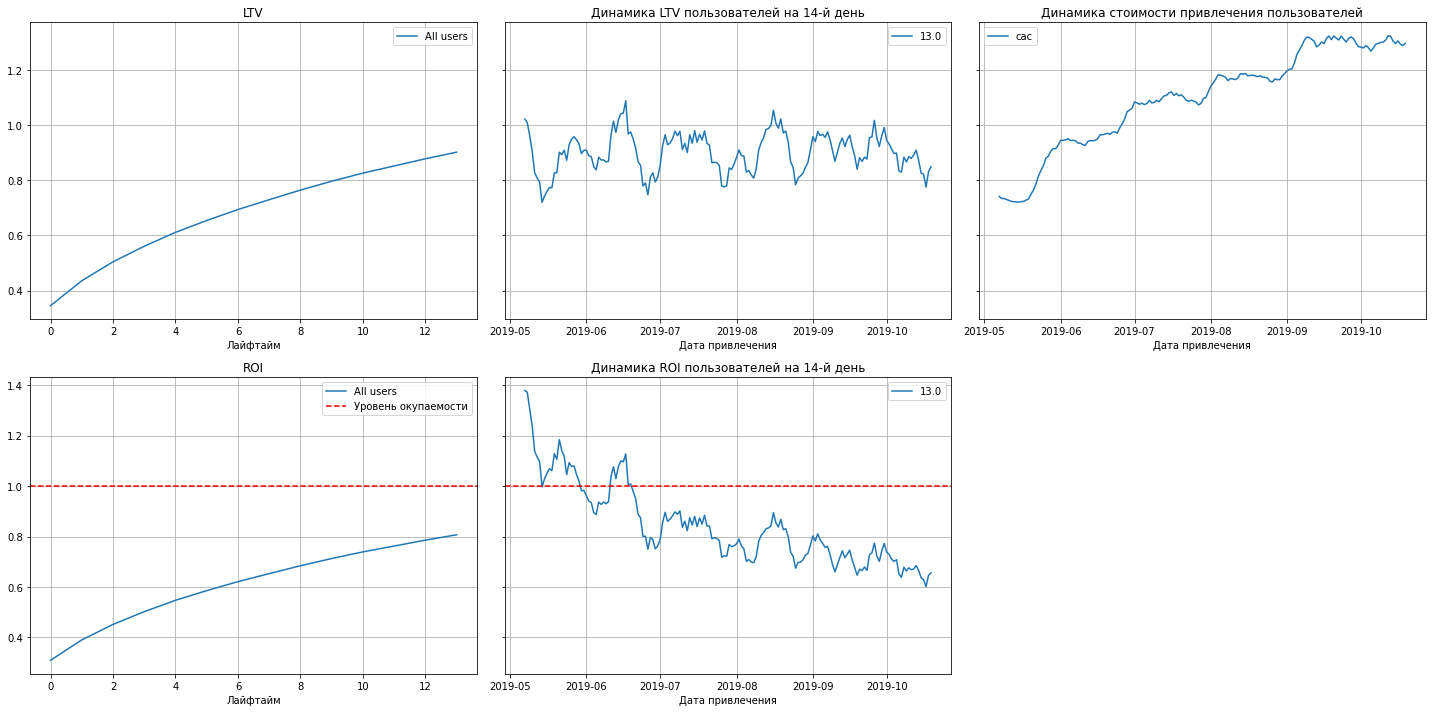

In [33]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Видим, что график LTV стабильный, поодчиняется общему закону, с ним никаких проблем нет. Динамика LTV тоже выглядит хорошо. CAC постоянно растет, значит, дело в увеличении затрат на пользователей. Считаю, что дело связано с большим количество рекламы, покупаемой у TipTop, которая не приносит нужного количества пользователей.

Реклама не окупается даже на 14 день. Динамика ROI тоже постоянно падает, что не есть хорошо

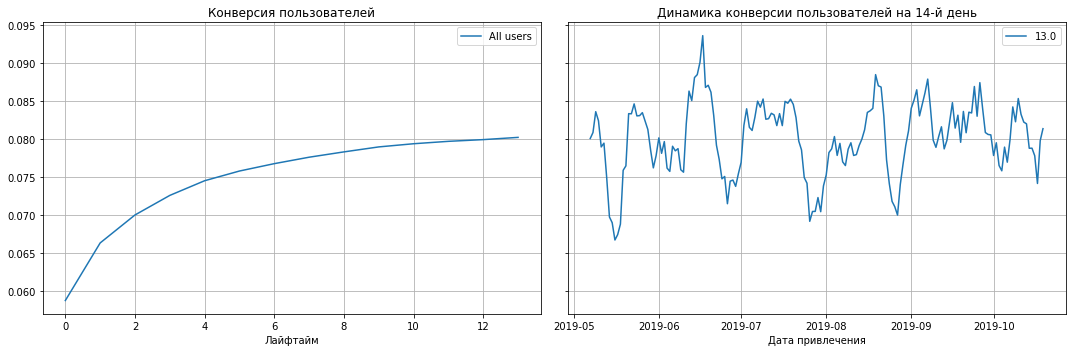

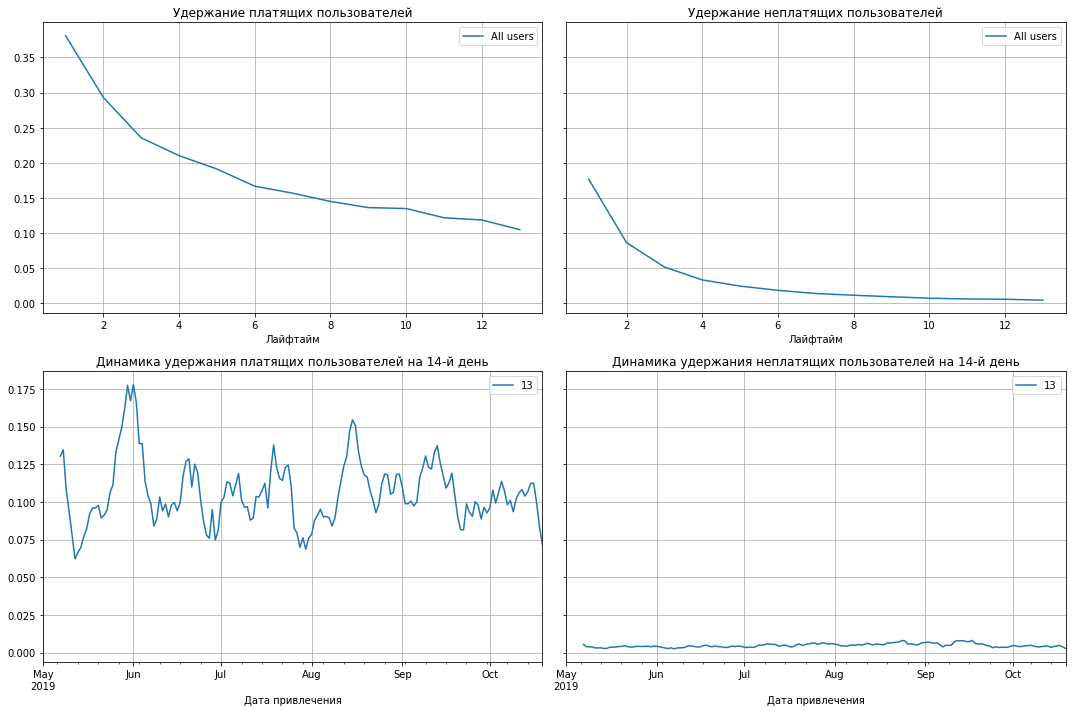

In [34]:
# Конверсия

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

# Удержание

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)
plot_retention(retention_grouped, retention_history, horizon_days)

В принципе, все графики выглядят так, как нужно, за исключеним последнего.

На графике конверсии мы видим стандартную зависимость, значит, с конверсией все в порядке. По ее динамике мы видим, что конверсия в среднем увеличивается, что полностью устраивает компанию.

Удержание платящих и неплятащих пользователей выглядит естественно, удержание неплатящих ниже, но их зависимости выглядят как по учебникам, поэтому это нормально.

Динамика удержания платящих пользователей выглядит хорошо, она примерно постоянна, а вот динамика удержания неплатящих  пользователей крайне низка, скорее всего, существует какая-то проблема, может, слишком сильное навязывание покупки или что-то подобное, что отталкивает пользователей

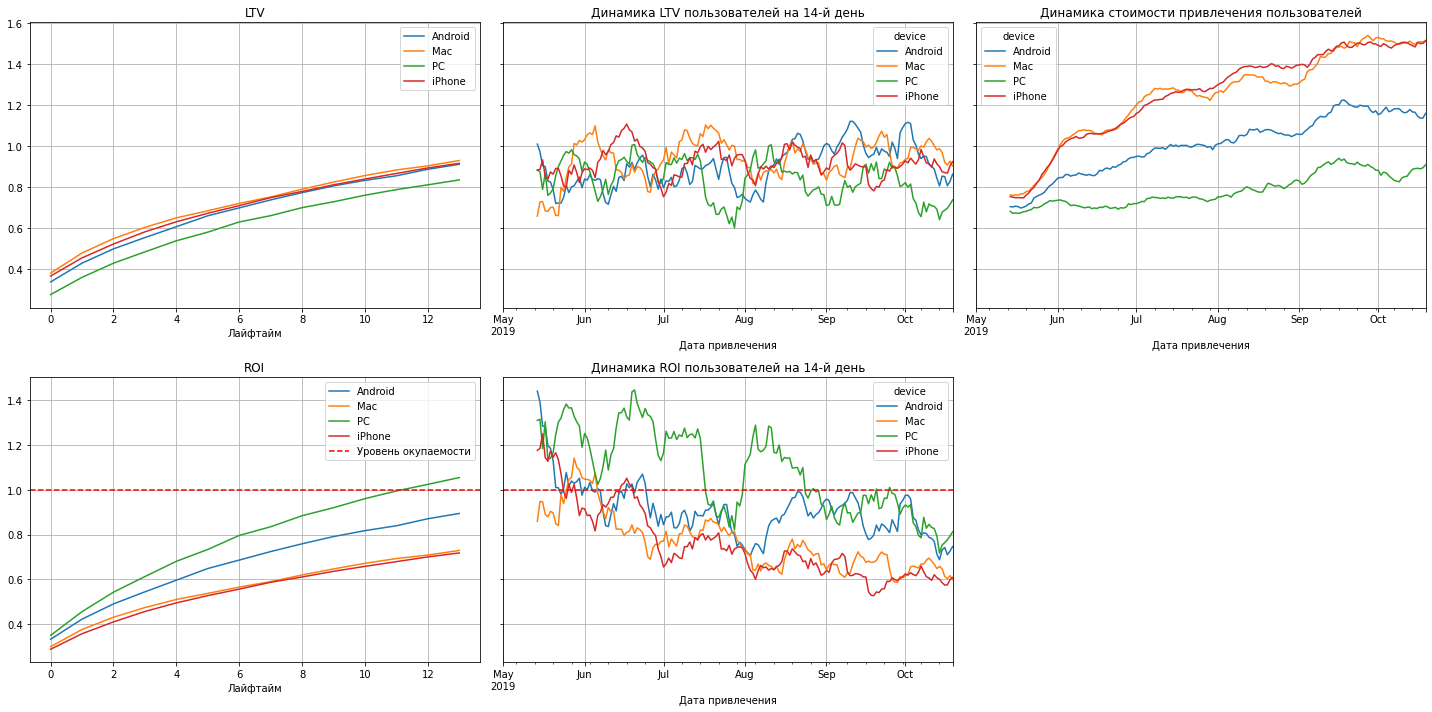

In [35]:
# Окупаемость с разбивкой по устройствам

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

LTV одинаков на почти всех платформах, на PC он немного ниже, но некритично. Динамика LTV у всех платформ +- одинакова(но, опять же, PC остает), значит, дело не в этом.

Наиболее дорогая стоимость привлечения пользователей на iPhone и Mac, наиболее низкая - на PC. Именно это объясняет, что окупается реклама только на PC. С iPhone и Mac все хуже, они уверенно и стабильно не окупаются, более того, по последнему графику мы видим, что с каждым месяцем ситуация хуже и хуже, тогда как на PC падение не столь критично (и все еще прибыльно). Несмотря на то, что динамика ROI на Android чуть ниже PC, а динамика пользователей - выше, разница в стоимости привлечения клиентов не позволяет окупить привлечение пользователей с Android

Итого - прибыльной является только 1 платформа - PC

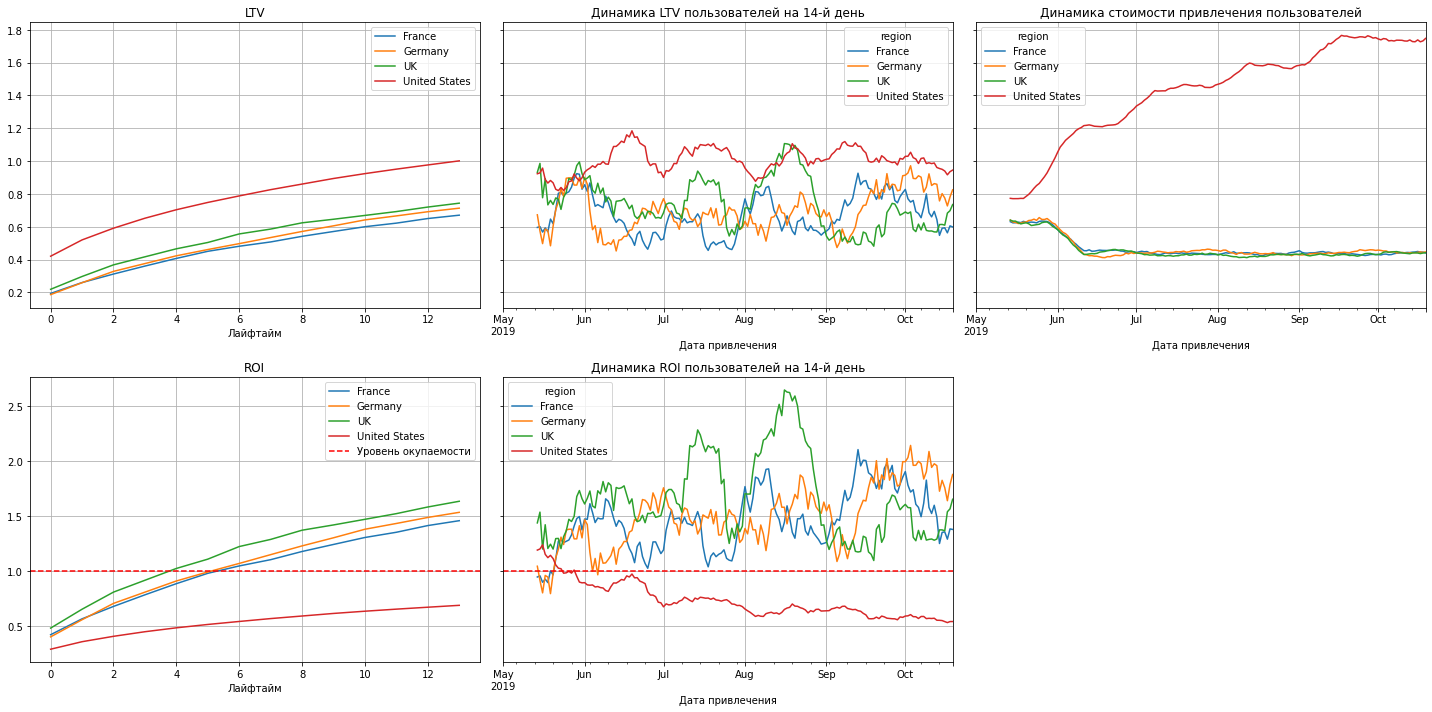

In [36]:
# Окупаемость с разбивкой по странам

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

По совокупности графиков мы видим, что наиболее убыточной является US, так как стоимость привлечения постоянно растет, а динамика ROI постоянно падает. Остальные страны уверенно приносят большую прибыль, на 1 месте - Germany

Отдельно стоит отметить динамику привлечения пользователей: в то время как стоиомсть привлечения клиентов из US постоянно возрастает, стоимость привлечения во всех остальных странах сначала падала (с 1 до 3 недели июня), а потом осталась такой же низкой на протяжении остального времени

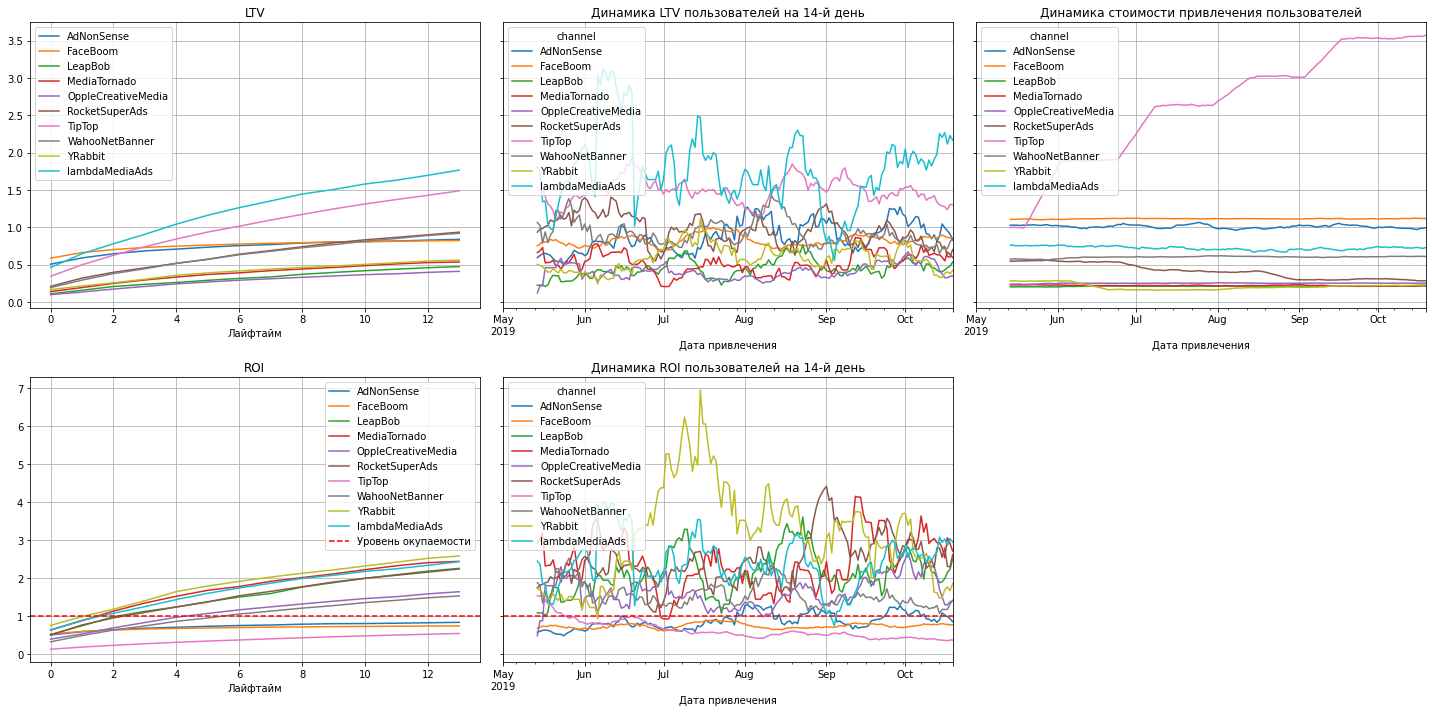

In [37]:
# Окупаемость с разбивкой по каналам привлечения

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

- LTV и динамика LTV выше всего у lambdaMediaAds и TipTop-а, самая низкая - у AdNonSence. 
- Динамика стоимости привлечения TipTop-а постоянно растет, у FaceBoom-а она постоянна, у RocketSuperAds она вообще падает, у остальных +- стабильна
- YRabbit, MediaTornado, lambdaMediaAds, LeapBob и RocketSuperAds наиболее прибыльны, тогда как TipTop, FaceBoom и AdNonSense постоянно убыточны (а я так верил в последний:( )

### Проверка рынков в разбивке по странам

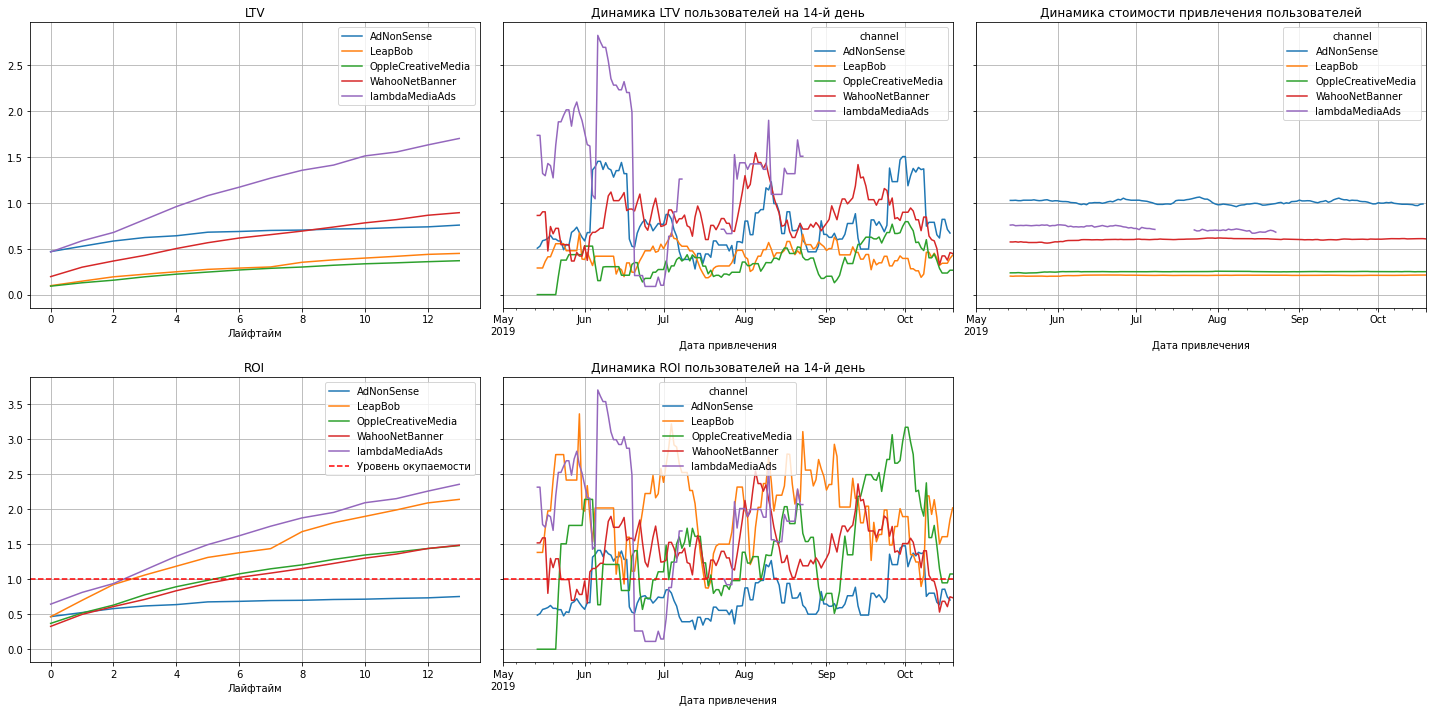

In [38]:
profiles_FR = profiles.query('region == "France"')
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_FR, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

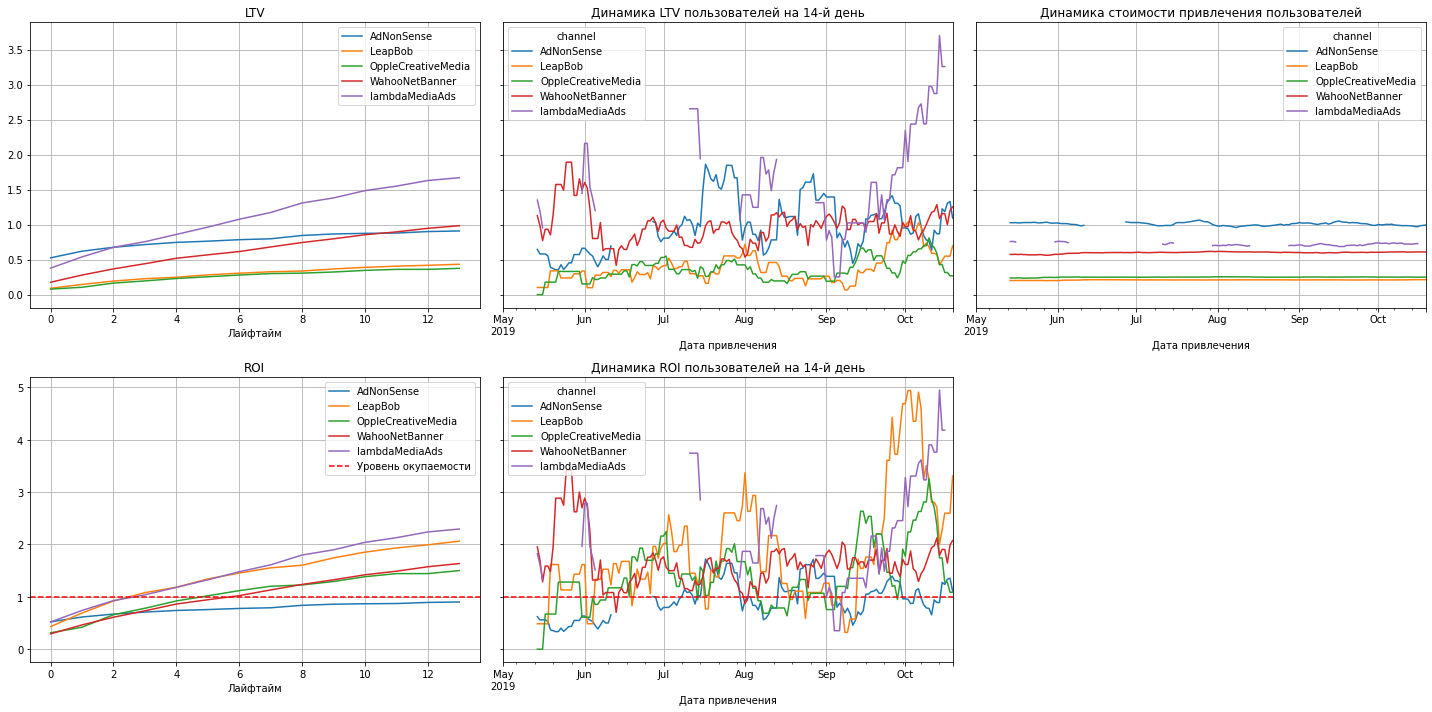

In [39]:
profiles_GR = profiles.query('region == "Germany"')
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_GR, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

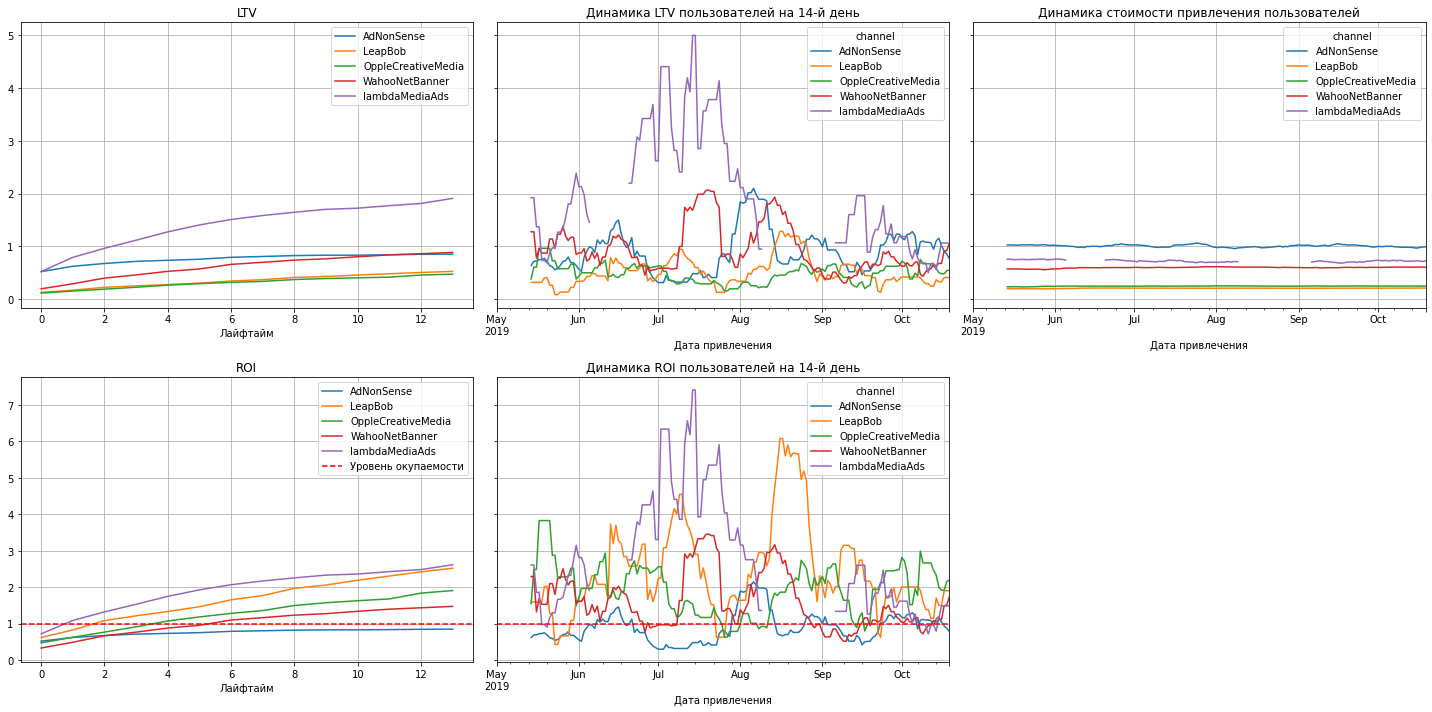

In [40]:
profiles_UK = profiles.query('region == "UK"')
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_UK, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

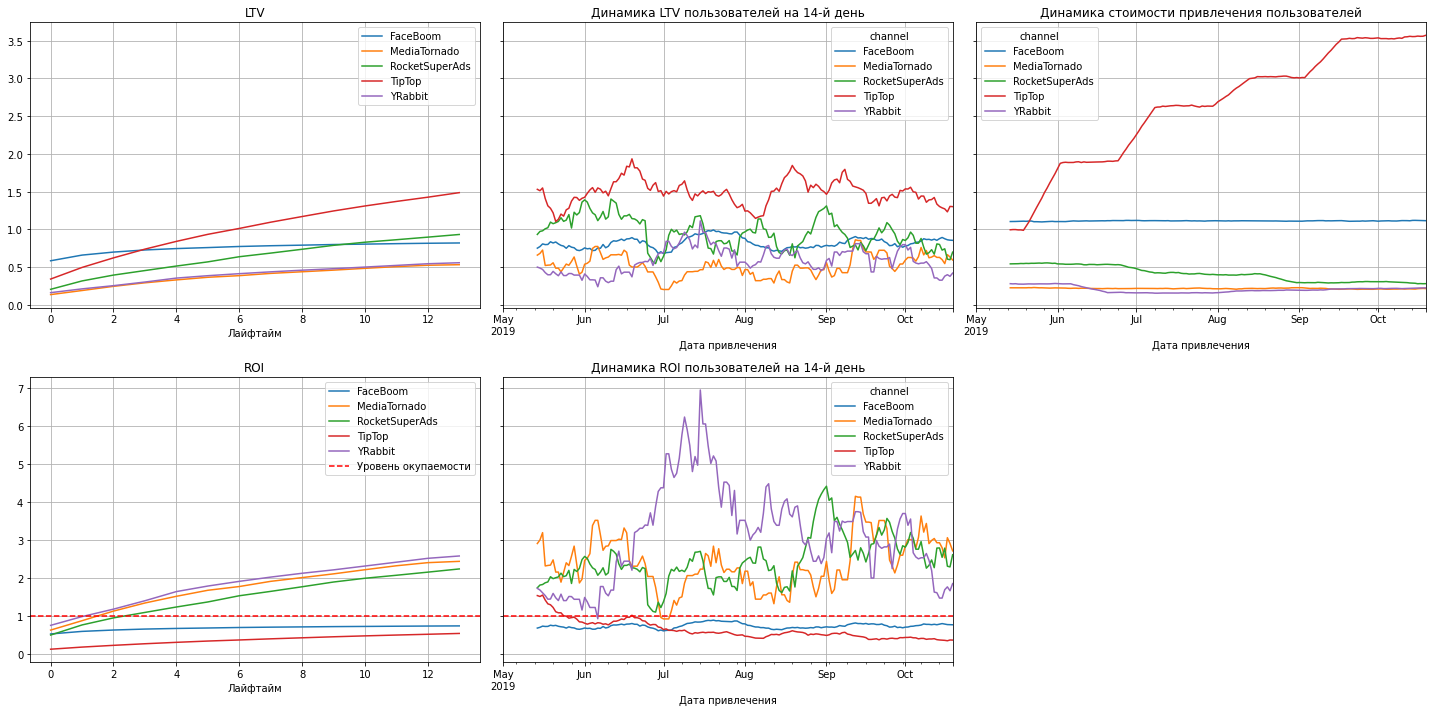

In [41]:
profiles_USA = profiles.query('region == "United States"')
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_USA, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

А здесь мы решили проверить теорию, что проблема в 1 конкретнм рынке - американском, так как преобладающее количество ползователей именно оттуда. Здесь мы видим практически такую же ситуацию, как и до этого - неокупаемость рекламы у главных каналов привлечения - FaceBoom и TipTop.

Стоит заметить, что в странах, где присутствуют компании AdNonSense, TipTop и FaceBoom, ни одна из них не приносит прибыли, а приносит сиключительно убытки. В странах, где есть канал привлечения lambdaMediaAds, он занимает уверенное первое место по прибыли.

Несмотря на то, что LTV и его динамика самые высокие у TipTop-а, крайне высокая стоимость привлечения новых пользователей нивелирует все преимущества данного канала привлечения. Вместо него стоит обратить внимание на RocketSuperAds, MediaTornado и YRabbit. Иначе говоря, любые каналы привлечения кроме тех, что выбраны компанией для массовых закупок

Подытог мы сделаем в виде ответов на вопросы, заданные в начале темы. Для удобства я их продублирую:
- Окупается ли реклама, направленная на привлечение пользователей в целом?
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости?

Итак, проанализировав данные выше, можно придти к следующему **выводу:**
1. Реклама **НЕ окупается**. Причиной этому, по моему мнению, является неправильная фокусировка на **каналы привлечения**. Поясню - самые популярные каналы привлечения не приносят прибыли - FaceBoom и TipTop, несмотря на их процент купивших пользователей. Динамика ROI пользователей, пришедших через данные каналы привлечения, крайне низка и находится сильно ниже линии окупаемости
2. Теперь про **устройства**. Наиболее прибыльной(и, по факту, единственной) платформой является PC. Android еще как-то пытается держаться, тогда как iPhone и Mac ушли настолько глубоко, что, будь эти платформы акциями, их бы начали скупать люди со словами "Ну все, сейчас цена взлетит, как ракета, иксы не за горами". Скорее всего, дело в крайне высокой стоимости привлечения iPhone и Mac. Получается, еще 1 палка в сторону наибольшего количества клиентов из TipTop-а с их вечно растущими ценами.
3. **Страны**. Ну здесь все просто, самая убыточная страна - США, опять же, из-за крайне высокой цены на привлечение новых пользователей. Дело в том, что основная часть клиентов находитс в США и привлекается через TipTop и FaceBoom, реклама на которые не окупается

## Выводы и рекомендации

Здесь будет следующая структура: сначала краткое описание, что было сделано, после - выводы и остальное

Итак, что было **сделано:**
1. Были получены, проанализрованы и предобработаны данные. В частности, была выполнена проверка на явные дубликаты и ошибки в данных, изменены типы данных там, где необходимо, были составлены профили польователей с необходимыми для анализа данными.
2. Были проанализованы страны клиентов, их каналы привлечения и устройства на предмет экономической составляющей. Были построены соответствующие графики и сделаны выводы, о которых чуть позже.
3. Были посчитаны общие затраты на маркетинг, получена динамика стоимости привлечения клиентов, выявлены источники с наибольшими и наименьшими суммарными затратами на привлечение. Визуализация и промежуточные выводы - там же.
4. Была проведена оценка окупаемости рекламы, построены соответствующие графики и сделаны выводы, о которых прямо сейчас:

**Выводы:**
1. Реклама **не окупается**. Причина этому - отсутствие прибыли у главных каналов привлечения- FaceBoom и TipTop. несмотря на то, что у FaceBoom самый высокий процент процент купивших пользователей(12%), а у TipTop-а - 9.6% (4 место по данному критерию среди всех каналов привлечения). Динамика ROI пользователей, пришедших через данные компании, крайне низка и находится сильно ниже линии окупаемости
2. **Единственная** прибыльная **платформа - PC**. Наибольшее количество пользователей у iPhone и Mac, цена привлечения которых крайне высока, а прибыль вообще отсутствует как явление. Android так же приносит убытки, но не настолько большие, как iPhone и Mac. Возможно, причина этому - повышение стоимости привлечения клиентов (у PC это повышение минимальное, что позволило ему занять 1 место по ROI). Причем, ситуация с процентом людей, совершивших покупку, крайне противоположная(PC на последнем месте и тд), но это не меняет ситуацию в целом.
3. **Единственная** убыточная **страна - США**. Связано это с динамикой роста цен на привлечение пользователей, где США являются бесприкословным лидером. Но в LTV и динамике LTV США занимают такое же первое место(как и по количеству пользователей), поэтому стоит искать новые каналы привлечения для клиентов из этой страны, например, RocketSuperAds, MediaTornado и YRabbit.

**Рекомендации**
1. В первую очередь надо сменить приоритет на каналы привлечения. Так у самых популярных каналов - FaceBoom и TipTop нет никакой прибыли, а основная масса пользователей приходит от них (здесь мы не считаем органических пользователей, а именно рекламные источники). Рекомендую обратить внимание на такие источники как YRabbit, MediaTornado, lambdaMediaAds, LeapBob и RocketSuperAds. Каждая из этих компаний приносит стабильную высокую прибыль, а YRabbit и MediaTornado в моменте показывают самые высокие графики динамики ROI, имея при этом одни из самых низких стоимостей САС. В рынках всех стран, кроме США, лидирует по прибыли lambdaMediaAds, стоит попробовать увеличить затраты на рекламу с этой компанией
2. Удержание неплатящих пользователей крайне низкое, скорее всего, это связано с сильным ограничения функций для пользователей, не совершивших покупку. Рекомендуется найти и устранить данную проблему(например, слишком часто вылезающая реклама в главном меню или что-то подобное, сильно мешающее людям пользоваться приложением бесплатно, так как динамика удержания неплатящих пользователей крайне низкая). Может. стоит ввести пробный период или что-то еще, но здесь следует исходить конкретно из приложения, которого я не вижу.